## DCGAN using Keras
(https://github.com/eriklindernoren/Keras-GAN/tree/master/gan)

In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from IPython.display import clear_output, Image

import sys
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')
dir="/content/gdrive/My Drive/Colab Notebooks/EIP2/GAN/"
!ls

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive	sample_data


## Defining the discriminator

In our two-player game the discriminator takes the role of the police: given an image it has to find out whether the image is fake or not. Given this requirement, the input of our discriminator network is a (28x28x1) input patch, equal to the dimensions of an MNIST image. The output is a single node. The setup of the networks is roughly based on the [DCGAN paper](https://arxiv.org/abs/1511.06434) and one of its [implementations](https://github.com/carpedm20/DCGAN-tensorflow).

We use `LeakyReLU` in between the convolution layers to improve the gradients. 

In [0]:
def build_discriminator():    
  model = Sequential()
  
  model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))  #14x14x32

  model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))  #7x7x64
  model.add(ZeroPadding2D(padding=((0,1),(0,1))))  #8x8x64
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))  

  model.add(Conv2D(128, kernel_size=3, strides=2, padding="same")) # 4x4x128
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))  

  model.add(Conv2D(256, kernel_size=3, strides=1, padding="same")) # 4x4x256
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  
#   print("DISCRIMINATOR")
#   model.summary()
  
  input = Input(shape=(28,28,1))
  output = model(input)

  return Model(inputs=[input], outputs=[output])

## Defining the generator

The task of the generator, also known as "the counterfeiter", is to fool the discriminator by producing real-looking fake images. These images should eventually resemble the data distribution of the MNIST dataset.

The structure of the generator is comparable to the discrminiator but in reverse. We start with a random vector of noise (length=100) and gradually upsample. To improve the output of the generator we use `UpSampling2D` and normal convolutions instead of transposed convolutions (see also [this article](https://distill.pub/2016/deconv-checkerboard/)). The sizes of the layers are adjusted to match the size of our data (28x28 as opposed to the 64x64 of the DCGAN paper).

In [0]:
latent_dim = 100
img_channels = 1

def build_generator():
  model = Sequential()

  model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
  model.add(Reshape((7, 7, 128)))
  
  model.add(UpSampling2D())  # 14x14x128
  model.add(Conv2D(128, kernel_size=3, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  
  model.add(UpSampling2D())  #28x28x128
  model.add(Conv2D(64, kernel_size=3, padding="same")) #28x28x64
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))  #28x28x64 
  
  model.add(Conv2D(img_channels, kernel_size=3, padding="same"))
  model.add(Activation("tanh"))  #28x28x1

#   print("GENERATOR")
#   model.summary()
  noise = Input(shape=(latent_dim,)) # type Tensor, ?x100  
  gen_image = model(noise)

  return Model(noise, gen_image)

## Creating the models

We now defined the two separate networks but these still need to be combined in to two trainable models: one to train the discrmininator and one to train the generator. We first start with the simpler one, the **discriminator** model.

The model for the **generator** is a bit more complex. The generator needs to fool the discriminator by generating images. To train the generator we need to assess its performance on the output of the discriminator. For this we add both networks to the **combined** mode, this uses random noise as its input and outputs the eventual prediction of the discriminator on the generated images. 

The generator performs well if the combined model outputs 'real' on all inputs. This means, that the discriminator failed (which is a good thing for the generator). If we use normal back propagation on the combined mode,l discriminator would slowly be updated and will start classifying fake images as real. To prevent this we must freeze the part of the model that belongs to the discriminator.

This is done by setting the `trainable` parameter to `False` we prevent the layer of updating within this particular model (it is still trainable in the discriminator model).

Both models uses `Adam` as the optimizer with the default values for the momentum.

In [0]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
noise = Input(shape=(latent_dim,))
gen_image = generator(noise)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
decision = discriminator(gen_image)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(noise, decision)
combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print("COMBINED")
combined.summary()

W0826 03:26:43.890634 139884265846656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 03:26:43.892796 139884265846656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 03:26:43.895414 139884265846656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 03:26:43.921751 139884265846656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0826 03:26:43.930800 

COMBINED
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         856193    
_________________________________________________________________
model_1 (Model)              (None, 1)                 393729    
Total params: 1,249,922
Trainable params: 855,809
Non-trainable params: 394,113
_________________________________________________________________


## Reading mnist data

In [0]:
# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Generator is using tanh activation, for which we need to rescale image data into the range between -1 and 1.
X_train = (X_train/127.5) - 1.
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
#X_train = np.expand_dims(X_train, axis=3)

print(X_train[0,:10,:10,0])
print(X_train.shape)

11493376/11490434 [==============================] - 1s 0us/step
[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -0.76470588 -0.71764706]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -0.61568627  0.86666667  0.98431373]

In [0]:
def save_image(epoch):
    row, col = 5, 5
    noise = np.random.normal(0, 1, (row * col, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(row, col)
    cnt = 0
    for i in range(row):
      for j in range(col):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
    fig.savefig(dir + "Images/DCGAN_%d.png" % epoch)
    plt.close()

## Training GAN

With our models defined and the data loaded we start training our GAN. The models are trained one after another, starting with the discriminator. The discriminator is trained on a data set of both fake and real images and tries to classify them correctly. The combined model is trained on noise vectors and gives fake/real as output


In [0]:
comb_loss = []
disc_loss = []
comb_acc = []
disc_acc = []
plot_iteration = []

def train(epochs, batch_size, stats_interval, image_interval):
  
  # Adversarial ground truths of size (32,1)
  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for epoch in range(epochs+1):
      # ---------------------
      #  Train Discriminator
      # ---------------------
      # Select randomly x number of images where x=batch_size
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]
      
      # Sample noise and generate a batch of new images
      noise = np.random.normal(0, 1, (batch_size, latent_dim))
      gen_imgs = generator.predict(noise)

      # Train the discriminator (real classified as ones and generated as zeros)
      d_loss_real = discriminator.train_on_batch(imgs, valid)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
      disc_stats = 0.5 * np.add(d_loss_real, d_loss_fake)
      
      # ---------------------
      #  Train Generator (wants discriminator to mistake gen. images as real)
      # ---------------------
      comb_stats = combined.train_on_batch(noise, valid) # type list of len 2
            
      # Print statistics instead of plotting
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, disc_stats[0], 100*disc_stats[1], comb_stats[0], 100*comb_stats[1]))
      
      if epoch % stats_interval == 0:
        print("Saving stats", epoch)
        plot_iteration.append(epoch)
        comb_loss.append(comb_stats[0])
        comb_acc.append(comb_stats[1])
        
        disc_loss.append(disc_stats[0])        
        disc_acc.append(disc_stats[1])
        
      # At image_interval => save generated image samples
      if epoch % image_interval == 0:
        print("Saving image", epoch)
        save_image(epoch)  

#### For 10K iterations, discriminator loss 0.588, generator loss 1.28

In [0]:
train(epochs=20000, batch_size=32, stats_interval=200, image_interval=500)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.117303, acc.: 32.81%] [G loss: 0.655296, acc.: 65.62%]
Saving stats 0
Saving image 0


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.761764, acc.: 56.25%] [G loss: 0.828923, acc.: 43.75%]
2 [D loss: 0.527719, acc.: 78.12%] [G loss: 1.141843, acc.: 34.38%]
3 [D loss: 0.433069, acc.: 78.12%] [G loss: 1.067066, acc.: 34.38%]
4 [D loss: 0.281947, acc.: 95.31%] [G loss: 0.906334, acc.: 50.00%]
5 [D loss: 0.306782, acc.: 85.94%] [G loss: 0.932595, acc.: 46.88%]
6 [D loss: 0.308111, acc.: 90.62%] [G loss: 0.730173, acc.: 56.25%]
7 [D loss: 0.740180, acc.: 56.25%] [G loss: 1.018672, acc.: 37.50%]
8 [D loss: 0.821367, acc.: 62.50%] [G loss: 1.957985, acc.: 0.00%]
9 [D loss: 0.850697, acc.: 45.31%] [G loss: 1.856464, acc.: 0.00%]
10 [D loss: 0.751853, acc.: 62.50%] [G loss: 1.906334, acc.: 9.38%]
11 [D loss: 0.615284, acc.: 62.50%] [G loss: 1.536002, acc.: 21.88%]
12 [D loss: 0.586556, acc.: 68.75%] [G loss: 1.830462, acc.: 15.62%]
13 [D loss: 0.695106, acc.: 60.94%] [G loss: 2.032727, acc.: 12.50%]
14 [D loss: 0.770366, acc.: 59.38%] [G loss: 1.988977, acc.: 9.38%]
15 [D loss: 0.455726, acc.: 76.56%] [G loss: 1.

#### Plot statistics

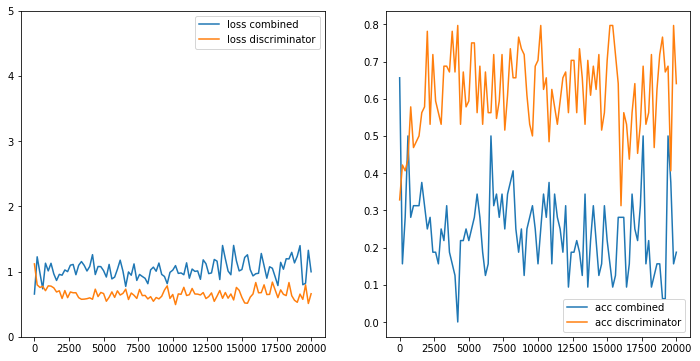

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 6)

ax1.plot(plot_iteration, comb_loss, label="loss combined")
ax1.plot(plot_iteration, disc_loss, label="loss discriminator")
ax1.set_ylim([0,5])
ax1.legend()

ax2.plot(plot_iteration, comb_acc, label="acc combined")
ax2.plot(plot_iteration, disc_acc, label="acc discriminator")
ax2.legend()

plt.show()

#### Morph instances 
If we slowly change the noise vector filled with zeros to one filled with -1 to 2 we see a **digit slowly changing from 5 to a 0.**

[[-1. -1.]]
[[-0.8 -0.8]]
[[-0.6 -0.6]]
[[-0.4 -0.4]]
[[-0.2 -0.2]]
[[0. 0.]]
[[0.2 0.2]]
[[0.4 0.4]]
[[0.6 0.6]]
[[0.8 0.8]]
[[1. 1.]]
[[1.2 1.2]]
[[1.4 1.4]]
[[1.6 1.6]]
[[1.8 1.8]]
[[2. 2.]]


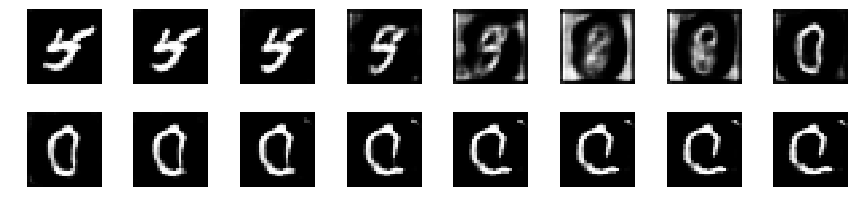

In [0]:
plt.figure(figsize=(12,3))

for i in range(16):
    noise = np.zeros([1,100]) - 1 + (i * 0.2)
    print(noise[:,:2])
    images = generator.predict(noise)
    
    image = images[0, :, :, :]
    image = np.reshape(image, [28, 28])
          
    plt.subplot(2, 8, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Maths with noise vectors

In [0]:
a = np.random.uniform(-1.0, 1.0, size=[1, 100])
b = np.random.uniform(-1.0, 1.0, size=[1, 100])

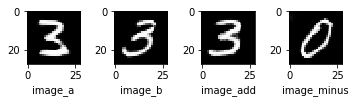

In [0]:
image_a = np.reshape(generator.predict(a)[0], [28, 28])
image_b = np.reshape(generator.predict(b)[0], [28, 28])
image_add = np.reshape(generator.predict(b + a)[0], [28, 28])
image_minus = np.reshape(generator.predict(b - a)[0], [28, 28])


plt.figure(figsize=(5,5))

plt.subplot(1,4,1)
plt.imshow(image_a, cmap='gray')
plt.xlabel("image_a")
#plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(image_b, cmap='gray')
plt.xlabel("image_b")

plt.subplot(1,4,3)
plt.imshow(image_add, cmap='gray')
plt.xlabel("image_add")

plt.subplot(1,4,4)
plt.imshow(image_minus, cmap='gray')
plt.xlabel("image_minus")

plt.tight_layout()
plt.show()

In [0]:
c = np.random.uniform(0, 1.0, size=[1, 100])
d = np.random.uniform(0, 1.0, size=[1, 100])

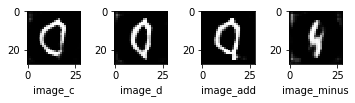

In [0]:
image_c = np.reshape(generator.predict(c)[0], [28, 28])
image_d = np.reshape(generator.predict(d)[0], [28, 28])
image_add = np.reshape(generator.predict(c + d)[0], [28, 28])
image_minus = np.reshape(generator.predict(d - c)[0], [28, 28])

plt.figure(figsize=(5,4))

plt.subplot(1,4,1)
plt.imshow(image_c, cmap='gray')
plt.xlabel("image_c")

plt.subplot(1,4,2)
plt.imshow(image_d, cmap='gray')
plt.xlabel("image_d")

plt.subplot(1,4,3)
plt.imshow(image_add, cmap='gray')
plt.xlabel("image_add")

plt.subplot(1,4,4)
plt.imshow(image_minus, cmap='gray')
plt.xlabel("image_minus")

plt.tight_layout()
plt.show()